In [1]:
import pandas as pd
import numpy as np
import gzip

# Specify the path to the compressed CSV file
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz'

def cps_data(file_path):
    # Use Pandas to read the compressed CSV file directly
    # The compression parameter is set to 'gzip'
    df = pd.read_csv(file_path, compression='gzip', header=0)

    # Drop rows where INCWAGE is 99999999
    df = df[(df['INCWAGE'] != 99999999) & (df['INCWAGE'] != 0) & (df['INCWAGE'] != 999)]
    

    df = df[(df['EDUC'] != 0) & (df['EDUC'] != 1)]

    df = df[(df['YEAR'] >= 1980) & (df['YEAR'] <= 2000)]

    dummy_df = pd.get_dummies(df['YEAR'], prefix='YEAR', drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

    def categorize_education(educ_code):
        if educ_code <= 10:
            return 'Up to Grade 10'
        elif 10 < educ_code <= 70:
            return 'High School'
        elif 70 < educ_code <= 123:
            return "Master's Degree"
        else:
            return 'Doctorate Degree'

    # Apply the function to create a new 'Education_Category' column
    df['Education_Category'] = df['EDUC'].apply(categorize_education)
    df = pd.get_dummies(df, columns=['Education_Category'], prefix='', prefix_sep='', drop_first=True)

    df = df[~((df['STATEFIP'] > 56) | (df['STATEFIP'] == 11))]

    dummy_df = pd.get_dummies(df['STATEFIP'], prefix='STATEFIP', drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

    df = df[(df['AGE'] >= 25) & (df['AGE'] <= 50)]

    df = df[df['SEX'] == 2]

    boolean_columns = ['YEAR_1981', 'YEAR_1982',
                       'YEAR_1983', 'YEAR_1984', 'YEAR_1985', 'YEAR_1986', 'YEAR_1987',
                       'YEAR_1988', 'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992',
                       'YEAR_1993', 'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997',
                       'YEAR_1998', 'YEAR_1999', 'YEAR_2000', 'High School', "Master's Degree",
                       'Up to Grade 10', 'STATEFIP_2', 'STATEFIP_4', 'STATEFIP_5',
                       'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9', 'STATEFIP_10', 'STATEFIP_12',
                       'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16', 'STATEFIP_17',
                       'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20', 'STATEFIP_21',
                       'STATEFIP_22', 'STATEFIP_23', 'STATEFIP_24', 'STATEFIP_25',
                       'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28', 'STATEFIP_29',
                       'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32', 'STATEFIP_33',
                       'STATEFIP_34', 'STATEFIP_35', 'STATEFIP_36', 'STATEFIP_37',
                       'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40', 'STATEFIP_41',
                       'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45', 'STATEFIP_46',
                       'STATEFIP_47', 'STATEFIP_48', 'STATEFIP_49', 'STATEFIP_50',
                       'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54', 'STATEFIP_55',
                       'STATEFIP_56']

    # Convert True and False to 1 and 0 in the specified columns
    df[boolean_columns] = df[boolean_columns].astype(int)

    
    
    return df

In [2]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz'

df = cps_data(file_path = file_path)

Number of times null hypothesis is rejected : 13 out of 50 simulations
Power of the test: 26.0 %
Bias for Coefficient of Treatment (True Value = 0.02): -0.0005229684782895828
MSE for Coefficient of Treatment (True Value = 0.02): 0.0014836038013456721


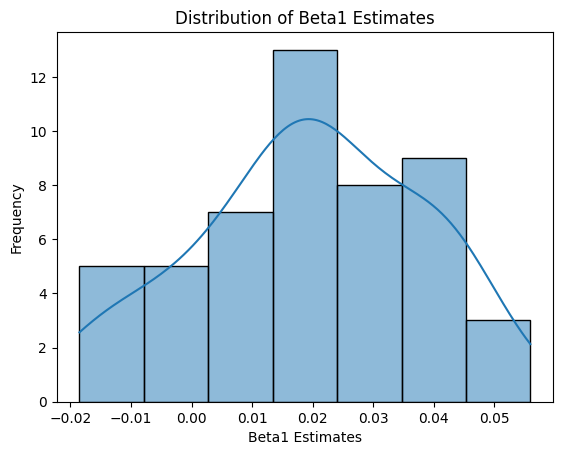

In [4]:
data = df.copy()
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
rho = 0.2

bias_values = []

N = 50
T = 20
true_beta1_value = 0.02 
squared_error_values = []
standard_error_values =[]
num_simulations = 50


for _ in range(num_simulations):
    data = df.copy()
    
    states = data['STATEFIP'].unique()
    

    # Randomly select half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)
    
    data['outcome'] = data.apply(lambda x: x['INCWAGE']*(1.02) if x['TREATMENT'] == 1 else x['INCWAGE'], axis=1)
    data['outcome'] = np.log(data['outcome'])

    X = data[['High School', "Master's Degree", 'AGE']]
    y = data['outcome']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # Obtain predicted values from the fitted model
    y_pred = model.predict(X)

    residuals = y - y_pred

    data['Residuals'] = residuals

    cps_agg = data.groupby(['STATEFIP', 'YEAR'])[['Residuals', 'TREATMENT']].mean().reset_index()

    # One-hot encode STATEFIP and YEAR
    dummy_df_state = pd.get_dummies(cps_agg['STATEFIP'], prefix='STATEFIP', drop_first=True)
    dummy_df_year = pd.get_dummies(cps_agg['YEAR'], prefix='YEAR', drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    # Convert True and False to 1 and 0 in the specified columns
    boolean_columns = ['STATEFIP_2', 'STATEFIP_4', 'STATEFIP_5', 'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9',
                        'STATEFIP_10', 'STATEFIP_12', 'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16', 'STATEFIP_17',
                        'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20', 'STATEFIP_21', 'STATEFIP_22', 'STATEFIP_23',
                        'STATEFIP_24', 'STATEFIP_25', 'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28', 'STATEFIP_29',
                        'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32', 'STATEFIP_33', 'STATEFIP_34', 'STATEFIP_35',
                        'STATEFIP_36', 'STATEFIP_37', 'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40', 'STATEFIP_41',
                        'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45', 'STATEFIP_46', 'STATEFIP_47', 'STATEFIP_48',
                        'STATEFIP_49', 'STATEFIP_50', 'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54', 'STATEFIP_55',
                        'STATEFIP_56', 'YEAR_1981', 'YEAR_1982', 'YEAR_1983', 'YEAR_1984', 'YEAR_1985', 'YEAR_1986',
                        'YEAR_1987', 'YEAR_1988', 'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992', 'YEAR_1993',
                        'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997', 'YEAR_1998', 'YEAR_1999', 'YEAR_2000']

    cps_agg[boolean_columns] = cps_agg[boolean_columns].astype(int)

    data = cps_agg.copy()

    X = data[['STATEFIP_2', 'STATEFIP_4', 'TREATMENT',
       'STATEFIP_5', 'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9', 'STATEFIP_10',
       'STATEFIP_12', 'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16',
       'STATEFIP_17', 'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20',
       'STATEFIP_21', 'STATEFIP_22', 'STATEFIP_23', 'STATEFIP_24',
       'STATEFIP_25', 'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28',
       'STATEFIP_29', 'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32',
       'STATEFIP_33', 'STATEFIP_34', 'STATEFIP_35', 'STATEFIP_36',
       'STATEFIP_37', 'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40',
       'STATEFIP_41', 'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45',
       'STATEFIP_46', 'STATEFIP_47', 'STATEFIP_48', 'STATEFIP_49',
       'STATEFIP_50', 'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54',
       'STATEFIP_55', 'STATEFIP_56', 'YEAR_1981', 'YEAR_1982', 'YEAR_1983',
       'YEAR_1984', 'YEAR_1985', 'YEAR_1986', 'YEAR_1987', 'YEAR_1988',
       'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992', 'YEAR_1993',
       'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997', 'YEAR_1998',
       'YEAR_1999', 'YEAR_2000' ]] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['Residuals'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['STATEFIP'].astype(str)})

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)


average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)


# Print the number of rejections
print(f"Number of times null hypothesis is rejected : {reject_count} out of {num_simulations} simulations")
print(f"Power of the test: {type1_error * 100} %")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()



